In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
from tqdm import tqdm
import time 

from datetime import datetime
from datetime import timedelta

from create_financial_database import get_credentials 
from SQLite_tools import query_stock_data, check_if_close_price_exists
from ticker_loader import load_SPY_components

In [2]:
df1 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_merged_data.xlsx', index_col=0)
df2 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_cbrt_data.xlsx', index_col=0)
df3 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_cbrt_cbrt_data.xlsx', index_col=0)
df4 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_relative_df_before_removal_of_outliers.xlsx', index_col=0)
df5 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_relative_df_clipping_at_1.xlsx', index_col=0)
df6 = pd.read_excel('../Data/Aux_datasets_while_dev/fundamental_relative_df.xlsx', index_col=0)
df1

,Date,EffectiveDate,Ticker,TotalRevenue,GrossProfit,EBIT,EBITDA,IncomeBeforeTax,NetIncome,TotalAssets,...,Relative_TotalAssets,Relative_TotalLiabilities,Cbrt_TotalRevenue,Cbrt_GrossProfit,Cbrt_EBIT,Cbrt_EBITDA,Cbrt_IncomeBeforeTax,Cbrt_NetIncome,Cbrt_TotalAssets,Cbrt_TotalLiabilities
0,1996-03-19,1996-01-31,ADI,280800000.00000000,142600000.00000000,53700000.00000000,71000000.00000000,54200000.00000000,40100000.00000000,1309400000,...,0.00000000,0.00000000,8.68381953,8.05403070,7.22580158,7.45353060,7.23324631,6.99509826,10.30405190,9.46248398
1,1996-03-31,1996-03-31,BBI,500000.00000000,600000.00000000,-1900000.00000000,-1800000.00000000,-1900000.00000000,-1900000.00000000,52900000,...,0.00000000,0.00000000,4.29752973,4.38547668,-4.98470302,-4.95484734,-4.98470302,-4.98470302,7.21376086,4.89042570
2,1996-03-31,1996-03-31,DVN,34000000.00000000,26600000.00000000,12300000.00000000,22400000.00000000,9800000.00000000,5600000.00000000,439900000,...,0.00000000,0.00000000,6.86801114,6.68323679,6.13433140,6.55683454,5.98140070,5.62080695,9.12793760,8.43432665
3,1996-03-31,1996-03-31,FI,194700000.00000000,160300000.00000000,28900000.00000000,44500000.00000000,24900000.00000000,14700000.00000000,2004300000,...,0.00000000,0.00000000,8.33759243,8.15941984,6.74510398,7.07648807,6.63437365,6.25703512,10.80317507,10.50283349
4,1996-03-31,1996-03-31,FRO,9400000.00000000,7400000.00000000,8000000.00000000,4700000.00000000,8200000.00000000,-500000.00000000,242000000,...,0.00000000,0.00000000,5.95376904,5.79759627,5.84803548,5.51244420,5.86410232,-4.29752973,8.54151761,7.93347141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6617,2024-02-28,2023-12-31,DAY,399700000.00000000,169800000.00000000,15400000.00000000,63800000.00000000,35500000.00000000,45600000.00000000,9010900000,...,0.00757000,-0.00952623,9.03125778,8.21178406,6.28946078,7.36550108,6.90103550,7.09571386,12.76689693,12.33539902
6618,2024-02-28,2023-12-31,DVN,3821000000.00000000,1315000000.00000000,1204000000.00000000,1854000000.00000000,1430000000.00000000,1152000000.00000000,25020000000,...,0.03213564,0.02736318,11.60610078,10.30893906,10.20841927,10.71001231,10.40541869,10.15846417,14.30096212,13.27500332
6619,2024-03-05,2023-12-31,NKTR,23885000.00000000,16602000.00000000,-30660000.00000000,-29008000.00000000,-42108000.00000000,-42079000.00000000,398033000,...,-0.09996970,-0.05596092,6.60376627,6.34220164,-6.78955561,-6.74790008,-7.03317824,-7.03263988,9.02706489,8.63549708
6620,2024-03-13,2023-12-31,PX,63067000.00000000,22909000.00000000,5729000.00000000,13260000.00000000,-68000.00000000,-1085000.00000000,834074000,...,0.02370765,0.05606620,7.35605023,6.57322441,5.63504835,6.18576939,-3.44306669,-4.68385351,9.80042600,9.05415160


In [3]:
df2

,Date,EffectiveDate,Ticker,TotalRevenue,GrossProfit,EBIT,EBITDA,IncomeBeforeTax,NetIncome,TotalAssets,TotalLiabilities
0,1996-05-13,1996-03-31,AAPL,1297.62881371,-749.48112259,-987.16941346,-971.17722942,-1055.22714725,-904.50416965,1736.24592494,1470.22780186
1,1996-08-12,1996-06-30,AAPL,1296.43996392,738.64372953,-333.22218516,-246.62120743,-370.84297693,-317.48021039,1748.43397317,1492.55570873
2,1996-12-19,1996-09-30,AAPL,1324.01136648,799.47882721,-355.68933045,100.00000000,341.99518934,292.40177382,1750.50325662,1489.70731305
3,1997-02-10,1996-12-31,AAPL,1286.44696629,734.95965966,-498.66309522,-462.60650092,-493.24241487,-487.69989611,1740.43764039,1493.30348225
4,1997-05-12,1997-03-31,AAPL,1169.85071268,671.65699615,-740.47206305,-721.76521603,-891.27368869,-1003.32228354,1649.37227423,1480.48802995
...,...,...,...,...,...,...,...,...,...,...,...
6617,2016-11-18,2016-09-30,WFM,1517.86056351,1060.88451151,540.61201758,654.21326204,527.76320879,444.79601811,1850.91262496,1460.76022209
6618,2017-02-16,2016-12-31,WFM,1700.57650574,1181.66575047,538.32126121,-534.84812412,538.32126121,456.29026354,1854.89330327,1456.53019776
6619,2017-05-19,2017-03-31,WFM,2053.23700378,1429.96625672,700.67961208,865.34974218,682.56241966,578.89603721,1867.49892027,1466.51743202
6620,2017-08-04,2017-06-30,WFM,1550.15607169,1082.36336585,569.80192153,667.19402717,558.27701717,473.26234912,1876.72433965,1466.20738604


In [4]:
df3

,Date,EffectiveDate,Ticker,TotalRevenue,GrossProfit,EBIT,EBITDA,IncomeBeforeTax,NetIncome,TotalAssets,TotalLiabilities
0,1996-05-13,1996-03-31,AAPL,10.90728916,-9.08350723,-9.95704715,-9.90298597,-10.18080186,-9.67097345,12.01905751,11.37090096
1,1996-08-12,1996-06-30,AAPL,10.90395716,9.03951241,-6.93284200,-6.27109635,-7.18450227,-6.82190321,12.04711563,11.42817415
2,1996-12-19,1996-09-30,AAPL,10.98071377,9.28116134,-7.08527883,4.64158883,6.99315787,6.63732883,12.05186637,11.42089968
3,1997-02-10,1996-12-31,AAPL,10.87586886,9.02445882,-7.92992493,-7.73399542,-7.90108629,-7.87138016,12.02872203,11.43008235
4,1997-05-12,1997-03-31,AAPL,10.53683424,8.75754776,-9.04696463,-8.97012819,-9.62358815,-10.01106204,11.81515881,11.39729091
...,...,...,...,...,...,...,...,...,...,...,...
6617,2016-11-18,2016-09-30,WFM,11.49239715,10.19896347,8.14632812,8.68106713,8.08127162,7.63344001,12.27802856,11.34644062
6618,2017-02-16,2016-12-31,WFM,11.93618088,10.57218813,8.13480558,-8.11727312,8.13480558,7.69863507,12.28682420,11.33547781
6619,2017-05-19,2017-03-31,WFM,12.71002371,11.26614310,8.88191257,9.52936341,8.80469111,8.33425643,12.31459461,11.36132744
6620,2017-08-04,2017-06-30,WFM,11.57333369,10.26733411,8.29038380,8.73810750,8.23410846,7.79292778,12.33483929,11.36052672


In [6]:
def histogram_of_feature(df, feature, title_addon, bins=200):
    plt.hist(df[feature], bins=bins)
    plt.title(f'Histogram of {feature} - {title_addon}')
    plt.show()

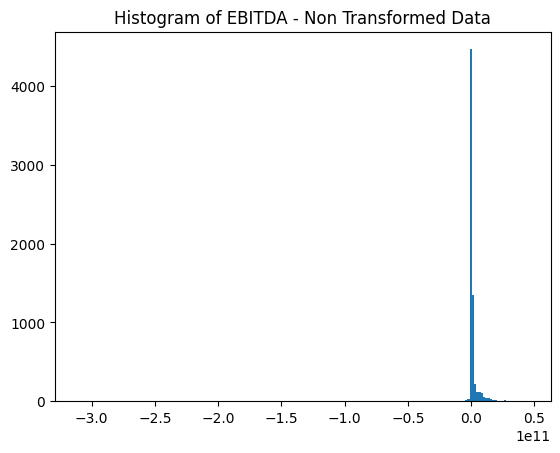

In [7]:
histogram_of_feature(df1, "EBITDA", "Non Transformed Data")

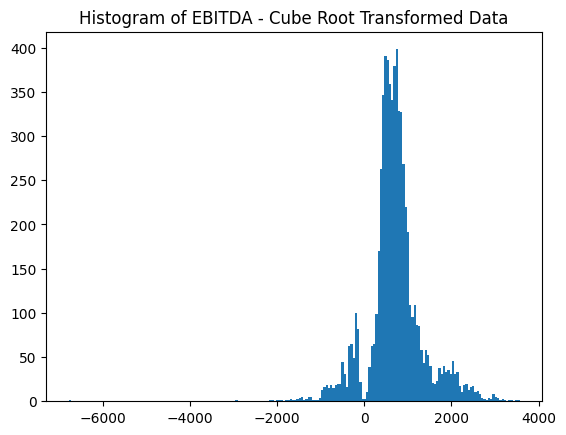

In [8]:
histogram_of_feature(df2, "EBITDA", "Cube Root Transformed Data")

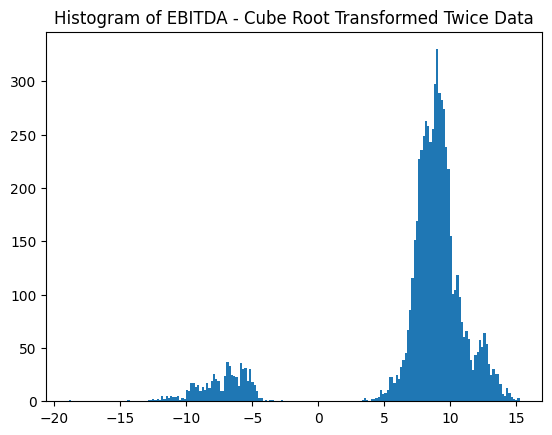

In [9]:
histogram_of_feature(df3, "EBITDA", "Cube Root Transformed Twice Data")

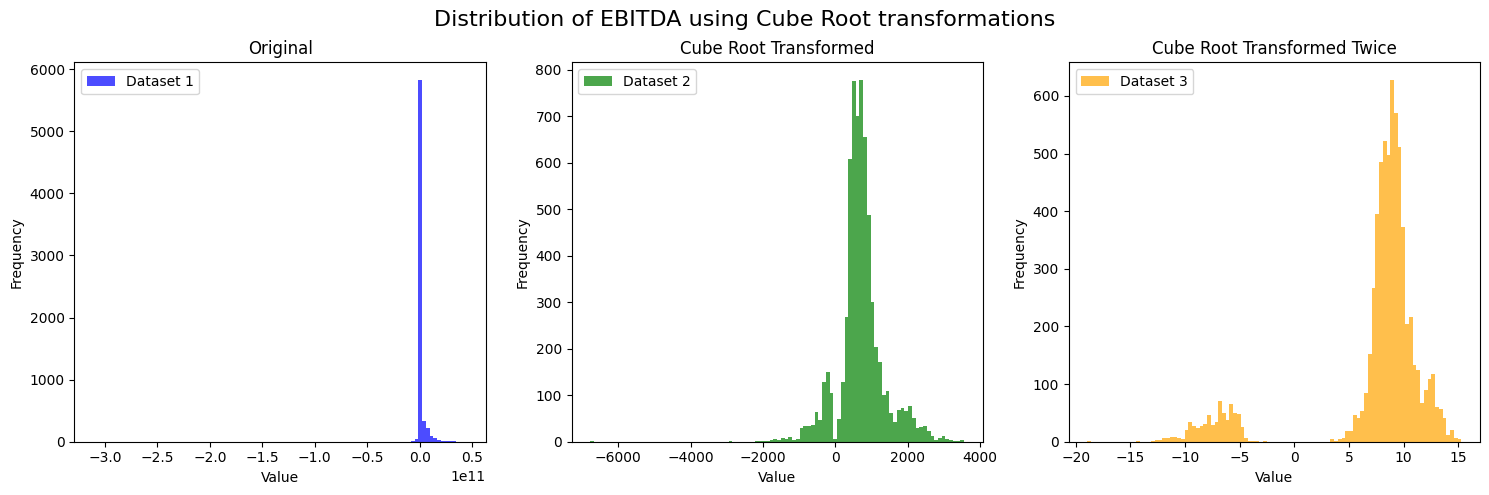

In [ ]:

def plt_3_distributions(df1, df2, df3, attribute):
    """
    Plot the distribution of the attribute for three dataframes side by side.

    Parameters:
        df1 (pd.DataFrame): First dataframe 
        df2 (pd.DataFrame): Second dataframe 
        df3 (pd.DataFrame): Third dataframe 
    """

    for idx, df in enumerate([df1, df2, df3], start=1):
        if attribute not in df.columns:
            raise ValueError(f"'{attribute}' column is missing in dataframe {idx}")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(f'Distribution of {attribute} using Cube Root transformations', fontsize=16)

    axes[0].hist(df1[f'{attribute}'], bins=100, color='blue', alpha=0.7, label='Dataset 1')
    axes[1].hist(df2[f'{attribute}'], bins=100, color='green', alpha=0.7, label='Dataset 2')
    axes[2].hist(df3[f'{attribute}'], bins=100, color='orange', alpha=0.7, label='Dataset 3')

    axes[0].set_title('Original')
    axes[1].set_title('Cube Root Transformed')
    axes[2].set_title('Cube Root Transformed Twice')

    for ax in axes:
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 1.02])
    plt.show()

plt_3_distributions(df1, df2, df3, 'EBITDA')

       Relative_TotalRevenue  Relative_GrossProfit        Relative_EBIT  \
count          6622.00000000         6622.00000000        6622.00000000   
mean            178.99324586         8271.59916722     -513831.56024575   
std           14537.50412421       673075.83782447    41597727.88580617   
min             -15.64135021         -348.81023382 -3385000001.00000000   
25%              -0.03671595           -0.06458217          -0.26112436   
50%               0.01805439            0.01771112           0.00000000   
75%               0.08314615            0.10531513           0.23225259   
max         1182999.00000000     54771999.00000000        1309.65069124   

       Relative_EBITDA  Relative_IncomeBeforeTax  Relative_NetIncome  \
count    6622.00000000             6622.00000000       6622.00000000   
mean       -0.18570050            -7745.89322302          0.18989902   
std        32.20154439           349858.58122472         18.69679697   
min     -1410.00000000        -19885

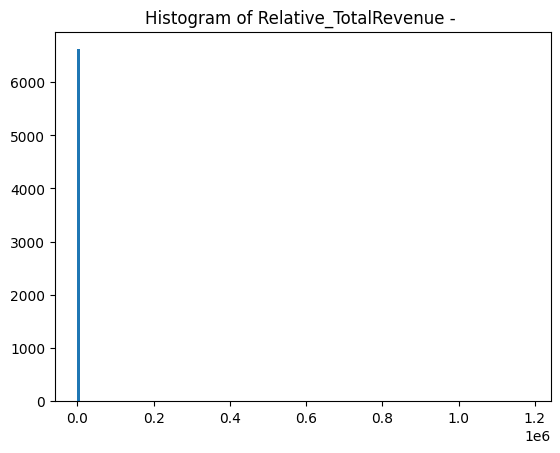

In [ ]:
print(df4.filter(like='Relative').describe())

histogram_of_feature(df4, "Relative_TotalRevenue", "")

       Relative_TotalRevenue  Relative_GrossProfit  Relative_EBIT  \
count          6622.00000000         6622.00000000  6622.00000000   
mean              0.03198560            0.02504774    -0.00743094   
std               0.21157903            0.32126748     0.52207589   
min              -1.00000000           -1.00000000    -1.00000000   
25%              -0.03671595           -0.06458217    -0.26112436   
50%               0.01805439            0.01771112     0.00000000   
75%               0.08314615            0.10531513     0.23225259   
max               1.00000000            1.00000000     1.00000000   

       Relative_EBITDA  Relative_IncomeBeforeTax  Relative_NetIncome  \
count    6622.00000000             6622.00000000       6622.00000000   
mean        0.00566530               -0.03074626         -0.03142896   
std         0.46741518                0.56564065          0.57582386   
min        -1.00000000               -1.00000000         -1.00000000   
25%        -0.1907

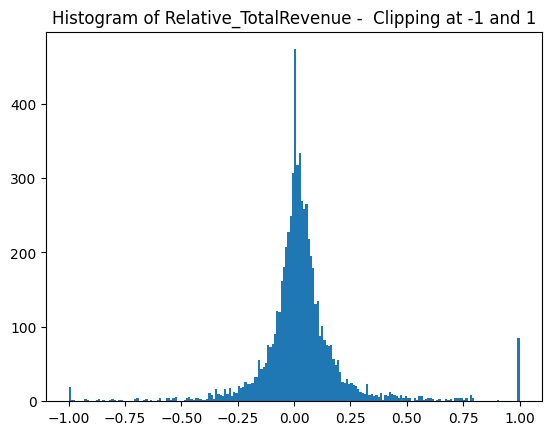

In [ ]:
print(df5.filter(like='Relative').describe())

histogram_of_feature(df5, "Relative_TotalRevenue", " Clipping at -1 and 1")

       Relative_TotalRevenue  Relative_GrossProfit  Relative_EBIT  \
count          6622.00000000         6622.00000000  6622.00000000   
mean              0.02171680            0.01341983    -0.00818600   
std               0.17382109            0.22504893     0.32412048   
min              -0.99999194           -0.99999998    -1.00000000   
25%              -0.03582319           -0.05418715    -0.13607665   
50%               0.01568398            0.00865780     0.00000000   
75%               0.07828153            0.08957704     0.12518378   
max               0.99981892            0.99392372     0.99982204   

       Relative_EBITDA  Relative_IncomeBeforeTax  Relative_NetIncome  \
count    6622.00000000             6622.00000000       6622.00000000   
mean        0.00355113               -0.01700419         -0.01965004   
std         0.30518475                0.33918661          0.34919151   
min        -0.99924167               -0.99999513         -0.99985900   
25%        -0.1180

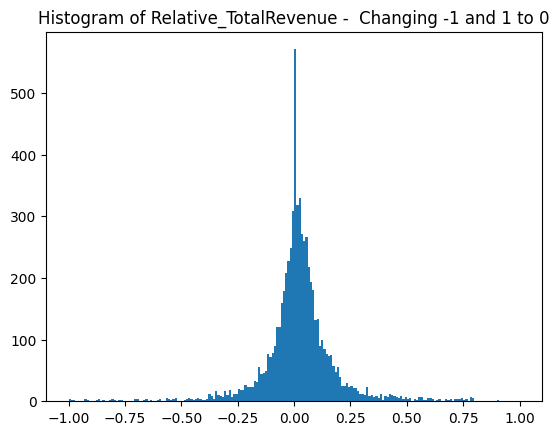

In [ ]:
print(df6.filter(like='Relative').describe())

histogram_of_feature(df6, "Relative_TotalRevenue", " Changing -1 and 1 to 0")

# Exploring Valutation Data

With some quick inspection, it seems very messy. Lets look at it.

In [ ]:
from SQLite_tools import query_stock_data, check_if_close_price_exists
pd.options.mode.chained_assignment = None  
valuation_data = pd.read_csv("../Data/Aux_datasets_while_dev/valuation_metrics_with_sectors.csv", index_col=0)

valuation_data.dropna(inplace=True)

# # Remove outliers
for feature in valuation_data.columns:
    if feature not in ["Ticker", "Date","Sector"]:
        # Removing outliers
        valuation_data = valuation_data[(valuation_data[feature] < 200) & (valuation_data[feature] > -200)]
        # Removing 0 values
        valuation_data = valuation_data[valuation_data[feature] != 0]


summary_df = valuation_data.groupby("Sector").describe()
ticker_counts = valuation_data.groupby("Sector")["Ticker"].nunique()

summary_df.drop(columns="count", level=1, inplace=True)
summary_df.drop(columns="min", level=1, inplace=True)
summary_df.drop(columns="max", level=1, inplace=True)
summary_df["Ticker", "count"] = ticker_counts

# Drop rows where Ticker count is less than 2
summary_df = summary_df[summary_df["Ticker", "count"] > 1]

summary_df_new = summary_df.xs("mean", axis=1, level=1)
summary_df_new.sort_values(by="P_E_Ratio", inplace=True, ascending=False)

for column in summary_df_new.columns:
    std = summary_df.xs("std", axis=1, level=1)[column]
    summary_df_new[column] = summary_df_new[column].apply(lambda x: f"{x:.1f}")
    tmp_summary_df_new = summary_df_new[column].copy()
    for i, val in enumerate(tmp_summary_df_new):
        summary_df_new[column][i] = f"{val} ± {std[i]:.1f}"

summary_df_new["Stocks"] = ticker_counts

print(summary_df_new)

summary_df_new

                          P_E_Ratio    P_S_Ratio   P_B_Ratio  Stocks
Sector                                                              
Technology              66.2 ± 44.1   13.5 ± 5.0   4.2 ± 3.3     103
Healthcare              60.5 ± 57.5  13.6 ± 12.5  4.3 ± 10.8      90
Real Estate             59.9 ± 49.2   17.2 ± 6.6  1.8 ± 12.3      44
Consumer Defensive      57.0 ± 34.9    5.8 ± 6.2  5.0 ± 14.8      46
Consumer Cyclical       53.0 ± 57.7    5.2 ± 9.9   3.2 ± 5.5     107
Industrials             51.3 ± 37.1   5.3 ± 10.9  3.4 ± 10.0     108
Communication Services  49.4 ± 52.0   8.4 ± 19.5  2.4 ± 12.4      42
Other                   49.0 ± 40.7    6.1 ± 6.1  2.8 ± 11.7      34
Basic Materials         48.5 ± 51.3    5.2 ± 6.5   2.5 ± 7.4      30
Financial Services      47.0 ± 69.4   9.7 ± 16.6   2.0 ± 3.2      99
Energy                  44.3 ± 50.4   7.1 ± 11.7  1.7 ± 13.3      54
Utilities               41.0 ± 34.0    4.5 ± 4.3   1.1 ± 0.8      32


C:\Users\emilh\AppData\Local\Temp\ipykernel_34200\1193171720.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_df_new[column][i] = f"{val} ± {std[i]:.1f}"
C:\Users\emilh\AppData\Local\Temp\ipykernel_34200\1193171720.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perfor

,P_E_Ratio,P_S_Ratio,P_B_Ratio,Stocks
Sector,,,,
Technology,66.2 ± 44.1,13.5 ± 5.0,4.2 ± 3.3,103
Healthcare,60.5 ± 57.5,13.6 ± 12.5,4.3 ± 10.8,90
Real Estate,59.9 ± 49.2,17.2 ± 6.6,1.8 ± 12.3,44
Consumer Defensive,57.0 ± 34.9,5.8 ± 6.2,5.0 ± 14.8,46
Consumer Cyclical,53.0 ± 57.7,5.2 ± 9.9,3.2 ± 5.5,107
Industrials,51.3 ± 37.1,5.3 ± 10.9,3.4 ± 10.0,108
Communication Services,49.4 ± 52.0,8.4 ± 19.5,2.4 ± 12.4,42
Other,49.0 ± 40.7,6.1 ± 6.1,2.8 ± 11.7,34
Basic Materials,48.5 ± 51.3,5.2 ± 6.5,2.5 ± 7.4,30


In [15]:
valuation_data = pd.read_csv("../Data/Aux_datasets_while_dev/valuation_metrics_with_sectors.csv", index_col=0)
print(valuation_data["P_E_Ratio"].describe(), "\n")
print(valuation_data["P_S_Ratio"].describe(), "\n")
print(valuation_data["P_B_Ratio"].describe(), "\n")


count   4626357.00000000
mean         53.65804283
std          67.63516768
min        -200.00000000
25%          24.89742857
50%          48.22644444
75%          81.03447761
max         200.00000000
Name: P_E_Ratio, dtype: float64 

count   4626357.00000000
mean         10.31125636
std          19.90806438
min        -200.00000000
25%           2.07218431
50%           4.99957543
75%          11.09475074
max         200.00000000
Name: P_S_Ratio, dtype: float64 

count   4626357.00000000
mean          3.70267363
std          17.59094836
min        -200.00000000
25%           0.87619027
50%           1.86289155
75%           3.73447026
max         200.00000000
Name: P_B_Ratio, dtype: float64 



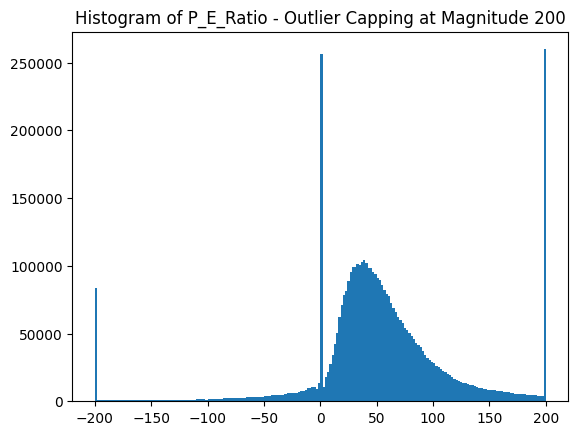

In [16]:
histogram_of_feature(valuation_data, "P_E_Ratio", "Outlier Capping at Magnitude 200")


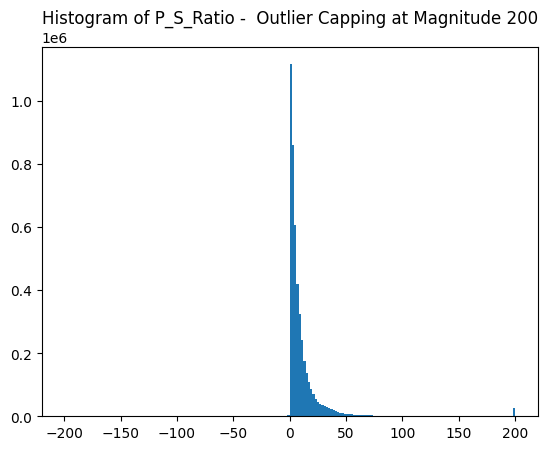

In [17]:
histogram_of_feature(valuation_data, "P_S_Ratio", " Outlier Capping at Magnitude 200")


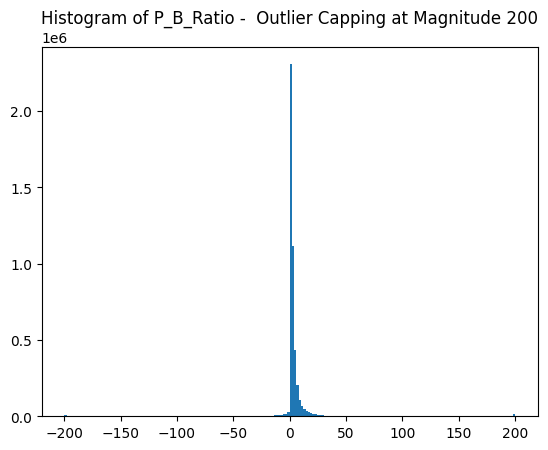

In [18]:
histogram_of_feature(valuation_data, "P_B_Ratio", " Outlier Capping at Magnitude 200")


# Exploring TA

There are certain stock that ruin the whole data. To combat that, i will consider larger companies only and look at their distribution

               MACD_10   MACD_signal_10     MACD_hist_10
count 5161972.00000000 5161972.00000000 5161972.00000000
mean       -0.00101253      -0.00105508       0.00004255
std         0.05658342       0.05615837       0.01383077
min       -21.19695241     -20.59120376      -3.52842110
25%        -0.01098689      -0.01018058      -0.00421566
50%         0.00420674       0.00416260       0.00004197
75%         0.01725897       0.01646576       0.00441962
max         0.64043571       0.68499289       1.74017522


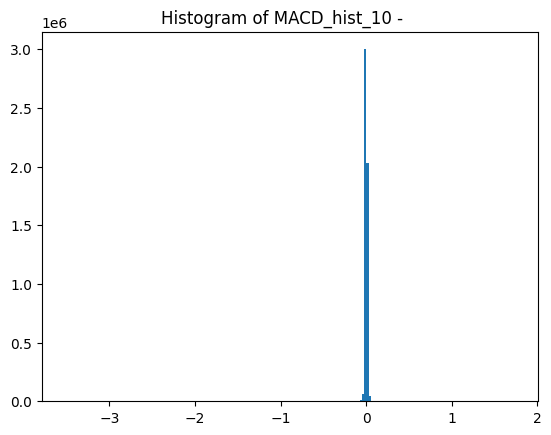

In [19]:
def create_ta_df_all(table):
    df = query_stock_data(table=table, ticker=f"all_stocks")
    return df


ta_df = create_ta_df_all("MACD_10")
print(ta_df.describe())

histogram_of_feature(ta_df, "MACD_hist_10", "  ")


In [ ]:
# No changes made to BB, looking good as is.

BB_data = create_ta_df_all(table = "Bollinger_Bands_10")
BB_data.describe()
histogram_of_feature(BB_data, "BB_upper_10", "  ")


         AROON_down_20      AROON_up_20
count 5161972.00000000 5161972.00000000
mean       44.70343795      53.70729345
std        35.71928127      35.97622091
min         0.00000000       0.00000000
25%        10.00000000      20.00000000
50%        40.00000000      55.00000000
75%        80.00000000      90.00000000
max       100.00000000     100.00000000



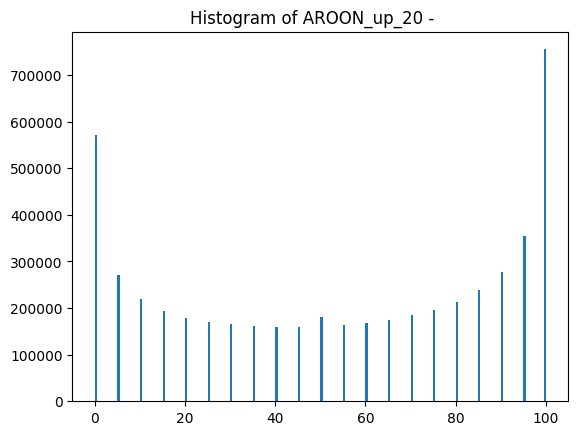

In [ ]:
# AROON looking as expected
ta_data = create_ta_df_all(table = "AROON_20")
print(ta_data.describe())
print("")

histogram_of_feature(ta_data, "AROON_up_20", "  ")

                EMA_20
count 5161972.00000000
mean        0.00107420
std         0.08328945
min        -0.90388607
25%        -0.02774528
50%        -0.00530788
75%         0.02014216
max        27.50935514



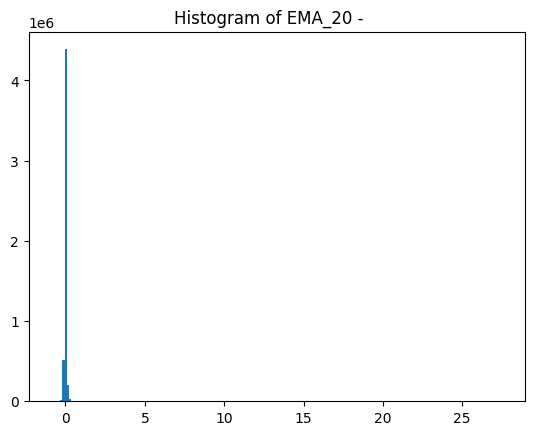

In [ ]:
# No changes made to EMA to handle outliers. Looks good as is.
ta_data = create_ta_df_all(table = "EMA_20")
print(ta_data.describe())
print("")

histogram_of_feature(ta_data, "EMA_20", "  ")

           Max_High_20
count 5161972.00000000
mean        0.08382353
std         0.57384282
min        -0.84873995
25%         0.01848086
50%         0.04528934
75%         0.09504326
max       444.00000000



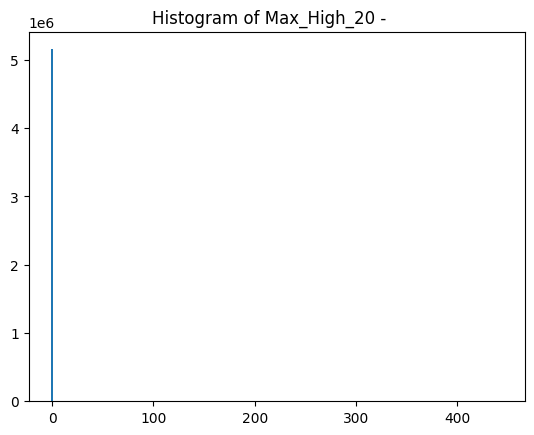

In [ ]:
# No changes made to Max High, or Min Low. These values look good as is.
ta_data = create_ta_df_all(table = "Max_High_20")
print(ta_data.describe())
print("")

histogram_of_feature(ta_data, "Max_High_20", "  ")

                RSI_20
count 5161972.00000000
mean        0.04066563
std         0.20676135
min        -1.00000000
25%        -0.09862729
50%         0.04270884
75%         0.18276416
max         1.00000000



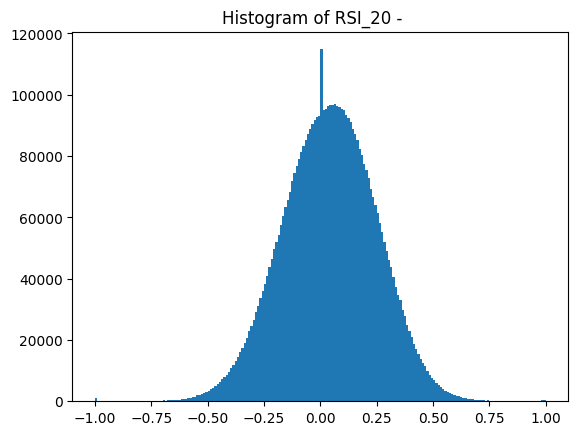

In [ ]:
# No changes made TO RSI

ta_data = create_ta_df_all(table = "RSI_20")
print(ta_data.describe())
print("")

histogram_of_feature(ta_data, "RSI_20", "  ")

                ROC_20
count 5161972.00000000
mean        1.32671795
std        11.91148555
min       -97.83152627
25%        -4.12059787
50%         1.11856823
75%         6.36826111
max       100.00000000



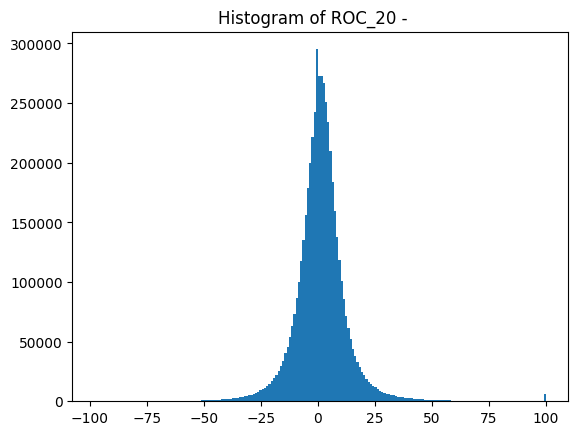

In [ ]:
# Changes made to ROC
# IF ROC is greater than 100, set it to 100, as anything beyond that is meaningless, or due to stock having their IPO recently.

ta_data = create_ta_df_all(table = "ROC_20")
print(ta_data.describe())
print("")

histogram_of_feature(ta_data, "ROC_20", "  ")

# Earnings data


In [ ]:
earnings_data = query_stock_data(table="Adjusted_Earnings_Data", ticker="all_stocks")
earnings_data

,Date,EffectiveDate,Ticker,EPSActual,EPSDifference
0,1996-02-01,1996-01-31,CSCO,0.03720000,0.03720000
1,1996-02-01,1996-01-31,HPQ,0.37550000,0.37550000
2,1996-02-01,1996-01-31,TJX,0.00360000,0.00360000
3,1996-02-15,1996-01-31,CPB,0.52000000,0.01000000
4,1996-02-15,1996-01-31,HRL,0.03000000,-0.01000000
...,...,...,...,...,...
72776,2024-06-28,2024-05-31,MKC,0.69000000,0.10000000
72777,2024-06-28,2024-05-31,NKE,1.01000000,0.18000000
72778,2024-06-28,2024-05-31,WBA,0.63000000,-0.05000000
72779,2024-07-01,2024-06-30,MCIC,0.00000000,0.00000000


In [ ]:
all_feature_data = query_stock_data(table="ML_Feature_Table", ticker="all_stocks")
all_feature_data

,Date,Ticker,Open,High,Low,Close,EPSActual,EPSDifference,Relative_TotalRevenue,Relative_GrossProfit,...,Financial_Services,Financials,Healthcare,Industrial_Goods,Industrials,Other,Real_Estate,Services,Technology,Utilities
0,1996-01-02,RCL,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,1996-01-02,WAT,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,1996-01-02,AEE,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
3,1996-01-02,GRA,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,1996-01-02,TRGP,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289171,2024-07-02,RSG,-0.04490907,0.23024189,-0.18659129,0.14605391,-0.02334179,-0.01405970,-0.03665491,1.17227911,...,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
5289172,2024-07-02,PLD,0.22565344,0.54669729,-0.33881926,0.42321889,-0.04074340,-0.01871493,0.10190062,0.08901920,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
5289173,2024-07-02,KR,-0.02129683,0.44739925,-0.25564486,-0.12284764,-0.02360768,-0.01955218,1.02682639,0.58855039,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
5289174,2024-07-02,CL,-0.03783523,0.27220863,-0.23626329,0.21846769,-0.03586246,-0.02181842,0.03996542,0.09664661,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
